# Data Exploration and Pre-Processing

This dataset contains chest x-ray images some of which are labeled as 'NORMAL' and otheras as 'PNEUMONIA' which are examples of patients that indeed have a case the potentially lethal respiratory infection. There are 5656 total images in a range of dimensions and all are greyscale. The dataset is sourced directly from [this Kaggle page](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) using the Kaggle API command (kaggle datasets download -d paultimothymooney/chest-xray-pneumonia). This kaggle page cites [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2) as its original data source.  

## Data loading and sifting

In [1]:
# dependences for data loading and sifting
import numpy as np 
import pandas as pd 

import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

# dictionary of volume of data per class per sample
class_balance_dict = {
    "Train Sample":[len(os.listdir(train_dir+"NORMAL")),len(os.listdir(train_dir+"PNEUMONIA"))],
    "Test Sample":[len(os.listdir(test_dir+"NORMAL")),len(os.listdir(test_dir+"PNEUMONIA"))],
    "Val Sample":[len(os.listdir(val_dir+"NORMAL")),len(os.listdir(val_dir+"PNEUMONIA"))]
}

# class balance dictionary as a dataframe with row index representing class and column index representing sample
import pandas as pd
class_balance_df = pd.DataFrame(class_balance_dict,index=['Normal', 'Pneumonia'])
class_balance_df

,Train Sample,Test Sample,Val Sample
Normal,1341,234,8
Pneumonia,3875,390,8


Text(0, 0.5, 'Percent Class Representation')

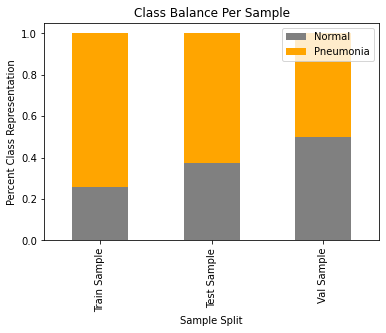

In [3]:
import matplotlib.pyplot as plt

# normalize data as percentage and rotate for plotting
class_balance_normalized = class_balance_df.T.apply(lambda x: x/x.sum(), axis=1)
 
# create stacked bar chart for students DataFrame
class_balance_normalized.plot(kind='bar', stacked=True, color=['gray', 'orange',])

# Add Title and Labels
plt.title('Class Balance Per Sample')
plt.xlabel('Sample Split')
plt.ylabel('Percent Class Representation')

The data comes already labeled and split for 3 way validation. The Train sample is, naturally, the largest of the 3 with over five thousand images, 66% of which are cases of pneumonia which will be the target prediction. The next largest is the test sample with over six hundred images of which 40% are trues cases of pneumonia. Finally, the validation set contains 16 images with each class being represented equally at 50%.  

## Sanity Check: Can the images be displayed easily?

In [4]:
# an example of (first) and Normal x-ray scan and (second) and x-ray scan showing pneumonia
Image.open("data/train/NORMAL/IM-0115-0001.jpeg").show()
Image.open("data/train/PNEUMONIA/person1001_bacteria_2932.jpeg").show()

## Generate Data from Sub-Directory Structure

In [5]:
# dependencies for modeling
from keras import layers
from keras import models
from keras import optimizers

In [6]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Sanity Check: is the data ready to fit a model?

In [7]:
# build a simple convultional neural network
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# compile model from above
base_model.compile(loss='binary_crossentropy',metrics=['acc'])

In [9]:
# fit the model to the training data and validate with the test sample
base_model.fit(train_data_generator, 
               batch_size=16,
               epochs=10,
               steps_per_epoch=25,
               validation_data=test_data_generator,
               validation_steps=15
               )

Epoch 1/10
25/25 [==============================] - 9s 363ms/step - loss: 1.1955 - acc: 0.6975 - val_loss: 1.1047 - val_acc: 0.6333
Epoch 2/10
25/25 [==============================] - 8s 324ms/step - loss: 0.4475 - acc: 0.8100 - val_loss: 0.4253 - val_acc: 0.8333
Epoch 3/10
25/25 [==============================] - 8s 325ms/step - loss: 0.3045 - acc: 0.8750 - val_loss: 0.4581 - val_acc: 0.7708
Epoch 4/10
25/25 [==============================] - 8s 307ms/step - loss: 0.2427 - acc: 0.8975 - val_loss: 0.4510 - val_acc: 0.7417
Epoch 5/10
25/25 [==============================] - 8s 329ms/step - loss: 0.1927 - acc: 0.9325 - val_loss: 0.2926 - val_acc: 0.8542
Epoch 6/10
25/25 [==============================] - 8s 327ms/step - loss: 0.2297 - acc: 0.9100 - val_loss: 0.3560 - val_acc: 0.8333
Epoch 7/10
25/25 [==============================] - 8s 310ms/step - loss: 0.1247 - acc: 0.9650 - val_loss: 0.4537 - val_acc: 0.8083
Epoch 8/10
25/25 [==============================] - 8s 303ms/step - loss: 0.

## Sanity Check: can the data be evaluated?

In [10]:
X_test, y_test = test_data_generator.next()
loss, accuracy = base_model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.4265 - acc: 0.8750


              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         4
         1.0       0.86      1.00      0.92        12

    accuracy                           0.88        16
   macro avg       0.93      0.75      0.79        16
weighted avg       0.89      0.88      0.86        16



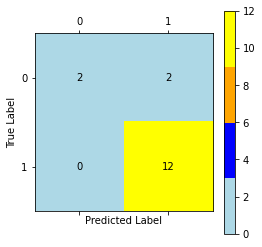

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.colors as colors

# generate predictions for the test set
y_pred = np.round(base_model.predict(X_test))

# calculate the confusion matrix and classification report
matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test,y_pred)

# create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(matrix)

# design plot aesthetics
plot_color_list = ["lightblue","blue","orange","yellow"]
plot_cmap = colors.ListedColormap(plot_color_list) 
# plot the confusion matrix, print the classification report
plt.matshow(matrix,cmap=plot_cmap)

# Add a color bar to the plot
plt.colorbar()

# Add labels to the quadrants
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(x=j, y=i, s=matrix[i, j], ha="center", va="center")

# Add axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Display the plot
print(report)
plt.show()

Formalize the model evaluation protocol above into a function for portability. 

In [12]:

def evaluate_model_performance(model,data_generator,verbose=True):
    """
    Takes in a keras model object and ImageDataGenerator object
    Samples a batch from the data generator
    Calcultes key performance indicators (KPIs)
    Prints loss and classification_report, and plots a confusion matrix
    If not verbose, returns loss, classification_report and confusion_matrix
    """
    
    # declare evaluation sample
    X_test, y_test = data_generator.next()

    # insantiate test prediction
    y_pred = np.round(model.predict(X_test))

    # evaluate KPIs
    loss, accuracy = model.evaluate(X_test,y_test)

    # calculate the confusion matrix and classification report
    matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test,y_pred)

    # create a ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(matrix)

    # design plot aesthetics
    plot_color_list = ["lightblue","blue","orange","yellow"]
    plot_cmap = colors.ListedColormap(plot_color_list) 
    # plot the confusion matrix, print the classification report
    plt.matshow(matrix,cmap=plot_cmap)

    # Add a color bar to the plot
    plt.colorbar()

    # Add labels to the quadrants
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(x=j, y=i, s=matrix[i, j], ha="center", va="center")

    # Add axis labels
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Display the plot
    print(report)
    plt.show()


1/1 [==============================] - 0s 2ms/step - loss: 0.3510 - acc: 0.8125
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         4
         1.0       0.80      1.00      0.89        12

    accuracy                           0.81        16
   macro avg       0.90      0.62      0.64        16
weighted avg       0.85      0.81      0.77        16



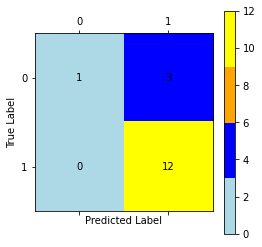

In [13]:
evaluate_model_performance(base_model,test_data_generator) 

## Visualizing Actications

In [47]:
from tensorflow.keras.preprocessing import image

### Load image from training set

(1, 150, 150, 1)


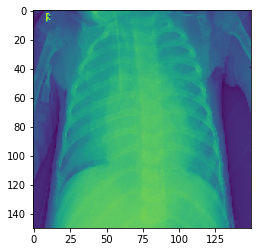

In [48]:
img_path = 'data/train/PNEUMONIA/person1004_bacteria_2935.jpeg'


img = image.load_img(img_path, target_size=(150, 150),color_mode="grayscale")
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

### visualize layer

In [49]:
from keras import models

In [50]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in base_model.layers[:4]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=base_model.input, outputs=layer_outputs)

In [54]:
activation_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 175233    
Total params: 175,553
Trainable params: 175,553
Non-trainable params: 0
_________________________________________________________________


Visualizing a single channel on a single layer

(1, 148, 148, 32)


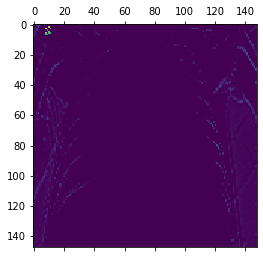

In [64]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

Visualizing all channels in a single layer

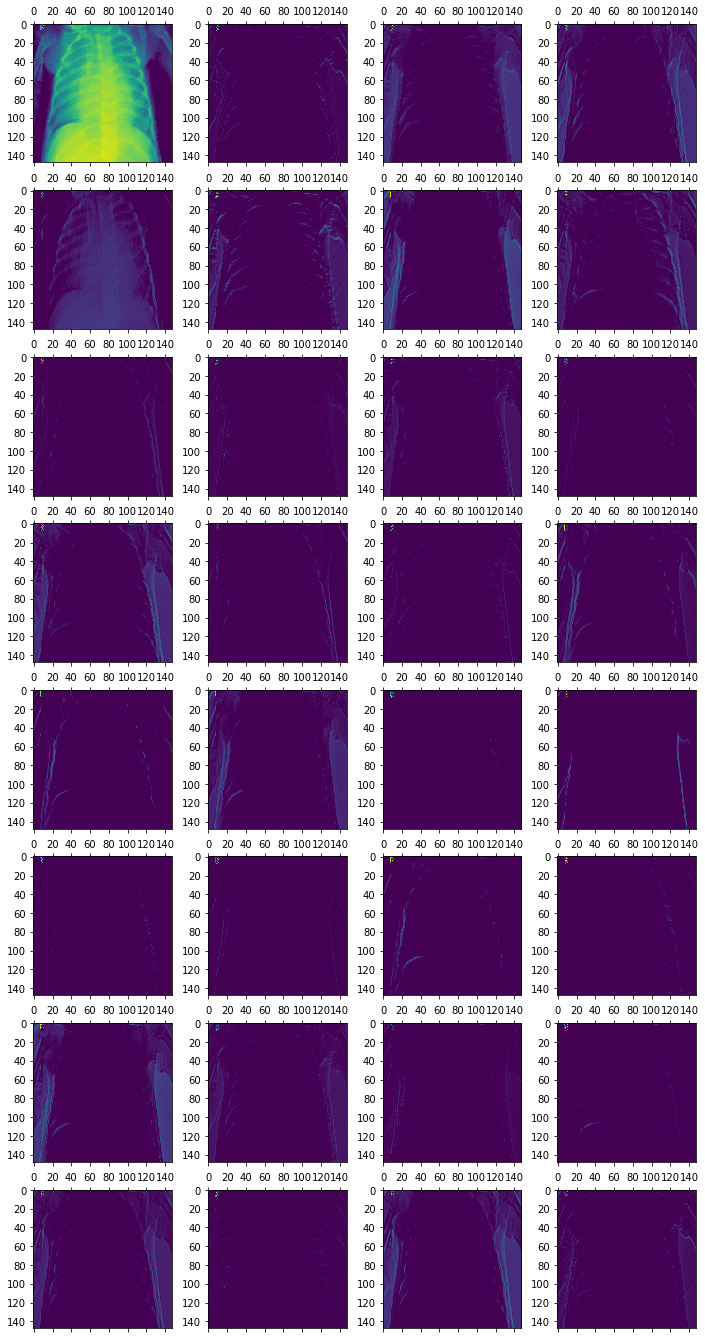

In [65]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

## Conlcusion 
The base model succesfully compiles and fits without any errors or warnings. The model also performs decently for a baseline model. I will continue tuning and optimizing thhe model in the [modeling notebook](/PROJECT-2/modeling.ipynb).  